<a href="https://colab.research.google.com/github/Srinidhi9113/MNIST_Model/blob/main/MNIST_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

torch.__version__,torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

## 1. Getting our Dataset

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'dataset',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root = 'dataset',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 9912422/9912422 [00:00<00:00, 107400806.09it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102744439.21it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23511924.08it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21050308.03it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [3]:
len(train_data)

60000

In [4]:
image,label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [5]:
classes = train_data.classes

## 2. Visualising images

Text(0.5, 1.0, '5 - five')

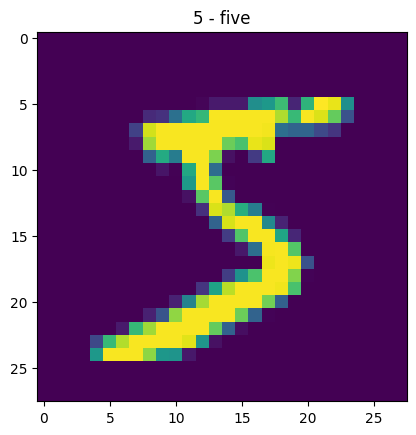

In [6]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(classes[label])

## 3. Prepare DataLoader

In [7]:
from torch.utils.data import DataLoader

train_DataLoader = DataLoader(dataset=train_data,
                              batch_size=64,
                              shuffle=True,
                              )
test_DataLoader = DataLoader(dataset=test_data,
                             batch_size = 64,
                             shuffle = False)

In [8]:
len(train_DataLoader)

938

In [9]:
train_features_batch,train_labels_batch = next(iter(train_DataLoader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

## 3.1 Building a Lightning DataModule

In [10]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 42.6 MB/s eta 0:00:00


In [49]:
from torchvision import datasets,transforms
from torch.utils.data import random_split
import pytorch_lightning as pl

class MNISTDataModule(pl.LightningDataModule):
  def __init__(self,data_dir,batch_size,num_workers):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

  def prepare_data(self):
    datasets.MNIST(self.data_dir,train=True,download=True)
    datasets.MNIST(self.data_dir,train=False,download=True)

  def setup(self,stage):
    entire_dataset = datasets.MNIST(
        root=self.data_dir,
        train=True,
        download=False,
        transform=transforms.ToTensor()
    )
    self.train_ds,self.val_ds = random_split(entire_dataset,[50000,10000])

    self.test_ds = datasets.MNIST(
        root=self.data_dir,
        train=False,
        download=False,
        transform=transforms.ToTensor()
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_ds,
        batch_size=self.batch_size,
        num_workers=self.num_workers,
        shuffle=True
    )

  def val_dataloader(self):
    return DataLoader(
        self.val_ds,
        batch_size=self.batch_size,
        num_workers=self.num_workers,
        shuffle=True
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_ds,
        batch_size=self.batch_size,
        num_workers=self.num_workers,
        shuffle=False
    )



In [51]:
dm = MNISTDataModule(data_dir="dataset",batch_size=64,num_workers=1)

## 4. Building Our Model

In [11]:
from torch import nn

flatten_model = nn.Flatten()

x = train_features_batch[0]

x.shape,flatten_model(x).shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [42]:
import pytorch_lightning as pl
from torch import nn,optim
import torchmetrics
from torchmetrics import Metric

class MNISTModel(pl.LightningModule):
  def __init__(self,input_size,hidden_units,output_size):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_size,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_size)
    )
    self.loss_fn = nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.Accuracy(task='multiclass',num_classes=output_size)
    self.f1_score = torchmetrics.F1Score(task='multiclass',num_classes=output_size)


  def forward(self,x):
    return self.layer_stack(x)

  def common_step(self,batch,batch_idx):
    x,y = batch
    scores = self.forward(x)
    loss = self.loss_fn(scores,y)
    return loss,scores,y

  def training_step(self,batch,batch_idx):
    loss,scores,y = self.common_step(batch,batch_idx)
    accuracy = self.accuracy(scores,y)
    f1_score = self.f1_score(scores,y)
    self.log_dict({"train_loss":loss,"train_acc":accuracy,"train_f1_score":f1_score},
                  on_step=False,on_epoch=True,prog_bar=True)
    return loss

  def validation_step(self,batch,batch_idx):
    loss,scores,y = self.common_step(batch,batch_idx)
    self.log("val_loss",loss)
    return loss

  def test_step(self,batch,batch_idx):
    loss,scores,y = self.common_step(batch,batch_idx)
    self.log("test_loss",loss)
    return loss

  def configure_optimizers(self):
    return optim.Adam(self.parameters(),lr=0.001)

  def predict_step(self,batch,batch_idx):
    x,y = batch
    scores = self.forward(x)
    preds = torch.argmax(scores,dim=1)
    return scores

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
model = MNISTModel(input_size=784,hidden_units=50,output_size=10).to(device)

## 5. Build Trainer

In [52]:
trainer = pl.Trainer(accelerator="gpu",min_epochs=1,max_epochs=3,precision=16)

trainer.fit(model,dm)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params
---------------------------------------------------
0 | layer_stack | Sequential         | 39.8 K
1 | loss_fn     | CrossEntropyLoss   | 0     
2 | accuracy    | MulticlassAccuracy | 0     
3 | f1_score    | MulticlassF1Score  | 0     
---------------------------------------------------
39.8 K    Trainable params
0         Non-trainable params
39.8 K    Total params
0.159     Total estimated model params size

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [26]:
trainer.test(model,test_DataLoader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1467491239309311     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1467491239309311}]